# Small Language Models
This notebook explores several neural network architectures for language modeling tasks. The models are trained on an artificially generated language. To the task remains the same. To predict the probability of the next word $Y$ given the previous words $X$ in a sentence.

$$
P(Y | X) 
$$

## Background and Motivation
Training language models on real-world language data often requires extensive computational resources typically found in data centers. To explore the fundamental concepts of language modeling in a more accessible manner, we will use an artificially constructed language. This approach allows us to control complexity, understand the underlying mechanics, and ensure resource efficiency.

## Objective
Understand, implement, and compare different neural network architectures (RNN, LSTM, Transformer) in language modeling tasks using an artificially generated language.

## Tasks
1. **Artificial Language Generation for Training**: Generate an initial dataset of sentences using a simple, rule-based grammar (see below).
2. **Tokenization**: Convert these sentences into sequences of integers.
3. **Model Building**: Implement at least the first 3 models - a basic RNN (required), an LSTM (required), 1DCNN (required) and a Transformer (optional)
4. **Training**: Train each model on the artificial language dataset and evaluate the performance of each model while training on the validation set by showing the learning curves for each model and comparing them.

You can use the starter code provided below to get started. Feel free to modify the code as you see fit. The architecture of the models is up to you but can be simple. For example for the RNN it might look like this:

| Layer (type)            | Output Shape      | Param # |
|-------------------------|-------------------|---------|
| embedding_1 (Embedding) | (1, 35, 8)        | 208     |
| simple_rnn (SimpleRNN)  | (1, 50)           | 2,950   |
| dense (Dense)           | (1, 26)           | 1,275   |

Important is to choose an appropriate loss function for the next predicted token. In the above example, the vocabulary size is 25.

In [1]:
################# Keras with JAX Backend ################
##### We use the JAX backend for Keras
import jax 
print(jax.__version__)

##### We set the KERAS_BACKEND environment variable to "jax"
import os
os.environ["KERAS_BACKEND"] = "jax"

##### We import Keras
import keras
print(keras.__version__)

0.8.2


/Users/philneuburger/miniforge3/envs/msi-ml/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


3.13.0


## Strange Language

We use the following procedure to generate samples from the language

In [2]:
import random
# Define the grammar rules
expanded_grammar = {
    'S': [['NP', 'VP'], ['S', 'CONJ', 'S']],
    'NP': [['Det', 'ADJ', 'N'], ['Det', 'N'], ['Det', 'N', 'PP']],
    'VP': [['V', 'NP'], ['V', 'NP', 'PP'], ['V', 'ADV']],
    'PP': [['P', 'NP']],
    'Det': ['a', 'the'],
    'N': ['cat', 'dog', 'bird', 'tree'],
    'V': ['sits', 'runs', 'flies', 'jumps'],
    'ADJ': ['big', 'small', 'quick', 'lazy'],
    'ADV': ['quickly', 'slowly', 'carefully'],
    'P': ['on', 'in', 'under', 'over'],
    'CONJ': ['and', 'but', 'or']
}

def generate_sentence(symbol, depth=0, max_depth=5):
    if depth > max_depth:  # Limiting recursion depth
        return ''

    if symbol not in expanded_grammar:
        return symbol

    expansion = random.choice(expanded_grammar[symbol])
    if isinstance(expansion, list):
        return ' '.join([generate_sentence(sym, depth+1, max_depth) for sym in expansion]).strip()
    else:
        return expansion

### Generation of Training and Test Data 

Here we generate the training and test data for the language. 

In [3]:
import random
import numpy as np
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generating sentences
num_train = 1000                        # Number of training examples
num_test  = 2000                        # Number of test examples
num_sentences = num_train + num_test    # Number of sentences to generate
sentences = [generate_sentence('S') for _ in range(num_sentences)]

# Sample some sentences
for i in range(5):
    print(f"{i} {sentences[i]}")

max_length = max(len(sentence.split()) for sentence in sentences)

0 the small dog sits a tree on a small cat
1 the dog under a lazy bird runs the big cat on the bird
2 the cat on the bird on runs slowly
3 a lazy bird flies the quick dog on a dog over
4 the cat on the bird runs the dog over but a dog flies carefully


### Tokenization

In the Tokenization step, we convert the input text into integer numbers. 

In [4]:
import numpy as np
import jax.numpy as jnp
from keras.layers import TextVectorization

# Define TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=40, # Maximum vocabulary size (will be less)
    output_mode="int"
)

# Adapt the vectorization layer
vectorize_layer.adapt(sentences)

# Vectorize sentences (output is JAX-compatible)
sequences = vectorize_layer(sentences)
print(sequences[:4])

vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)


# get frequency of each word
#from collections import Counter
#word_counts = Counter()
#for sentence in sentences:
#    word_count

[[ 2 18  7 13  3  4 15  3 18  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  7 16  3 22  5 12  2 20  6 15  2  5  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  6 15  2  5 15 12 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 22  5 14  2 19  7 15  3  7 17  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]]
26


### Padding

Since the input text can have variable length, the tokenization added 0 at the end of the text to make all the text of the same length. However, we want that the text ends with a real token. So we take the 0 at the end and move it to the beginning of the text.

In [5]:
# Function to shift padding tokens to the beginning
def move_padding_to_front(sequence, padding_value=0):
    non_padding = sequence[sequence != padding_value]
    padding = sequence[sequence == padding_value]
    return jnp.concatenate([padding, non_padding])

# Apply the function to all sequences
adjusted_sequences = jnp.array([move_padding_to_front(seq) for seq in sequences])

# Print adjusted sequences
print(adjusted_sequences[:4])
del(sequences)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  2 18  7 13  3  4 15  3 18  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
   7 16  3 22  5 12  2 20  6 15  2  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  2  6 15  2  5 15 12 24]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3 22  5 14  2 19  7 15  3  7 17]]


### Training and Test Data
The first part of the sentences is used for training data the aim is to predict the last token of the sentence.


In [6]:
# Prepare X and y for training
X = adjusted_sequences[:num_train, :-1]
Y = keras.utils.to_categorical(adjusted_sequences[:num_train, -1], num_classes=vocab_size)

# Prepare X_test and y_test
X_test = adjusted_sequences[num_train:, :-1]
y_test = keras.utils.to_categorical(adjusted_sequences[num_train:, -1], num_classes=vocab_size)

# Changes end here
# The first sentence
print(f"The first sentence :\'{sentences[0]}\'")
print(f"The first sentence after tokenization and padding :\n{adjusted_sequences[0]}")
print(f"The first sentence X for training (note the last token is missing):\n{X[0]}")
print(f"The first sentence Y for training (note that this is one-hot-encoded):\n{Y[0]}") 

print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

The first sentence :'the small dog sits a tree on a small cat'
The first sentence after tokenization and padding :
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2 18  7 13  3  4 15  3 18  6]
The first sentence X for training (note the last token is missing):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2 18  7 13  3  4 15  3 18]
The first sentence Y for training (note that this is one-hot-encoded):
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Shape of X: (1000, 35)
Shape of Y: (1000, 26)


### Shapes and Embeddings
`X` is a sparse representation in the code. Instead of one-hot-coding the tokens, we are using the token index, i.e. every word / token corresponds to an interger valu. This is a more efficient representation of the data, but conceptually it is the same.

`Y` is one hot encoded has the shape Batch, Vocabulary. It is the one-hot encoded result of the next token. Note that, here we are using the **last predicted word**. This makes it easier in our code but is less efficient. In technical realizations people also use the word for all $t=1..T$ as the targets.

#### Embedding layer
The first step, we do from $X(B,T,V)$ to $X(B,T,C)$ is the embedding layer. This is a simple matrix multiplication. The size of the embedding layer `C` is a hyperparameter. 

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

EMB_DIM = 8  # Embedding dimension (a.k.a. C)
# Define the model

emb_model = Sequential()

emb_model.add(Embedding(vocab_size, EMB_DIM)) 
### 
# <---- Add your model here ---->
###

# Predict embeddings for the input data
embeddings = emb_model.predict(X)  # X is already prepared as input sequences
print(f"Shape {embeddings.shape} (Batch, Time, Embedding)")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Shape (1000, 35, 8) (Batch, Time, Embedding)


Starting from the embedding layer above. We can now apply the RNN, LSTM, 1DCNN, or Transformer.
### RNN

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

EMB_DIM = 8  # Embedding dimension (a.k.a. C)

rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, EMB_DIM))
rnn_model.add(SimpleRNN(16, return_sequences=False))
rnn_model.add(Dense(vocab_size, activation='softmax'))

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(X, Y, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1450 - loss: 3.0101 - val_accuracy: 0.1400 - val_loss: 2.8351
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2170 - loss: 2.6773 - val_accuracy: 0.2265 - val_loss: 2.5759
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.2430 - loss: 2.4085 - val_accuracy: 0.2190 - val_loss: 2.2839
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2480 - loss: 2.1367 - val_accuracy: 0.2150 - val_loss: 2.0928
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.2520 - loss: 1.9539 - val_accuracy: 0.2285 - val_loss: 1.9186
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.2740 - loss: 1.8212 - val_accuracy: 0.2520 - val_loss: 1.8174
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.2950 - loss: 1.7349 - val_accuracy: 0.2510 - val_loss: 1.7471
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.2830 - loss: 1.6691 - val_accuracy: 0.2565 -

#### LSTM
Adpot the code from the basic RNN and replace the `SimpleRNN` layer with an `LSTM` layer. 

#### 1DCNN
Start same as LSTM and RNN. Replace the `LSTM` layer with serval `Conv1D` layer as shown in the lecture slides. The last layer should only return a single value. There are two ways to do this.

If you use the Sequential API 
```python
cnn_model.add(Lambda(lambda x: x[:, -1, :]))
```

If you use the Functional API
```python
output_layer = Dense(vocab_size, activation='softmax')(x[:, -1, :]) # x is the output of the last Conv1D layer
```


In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

EMB_DIM = 8  # Embedding dimension (a.k.a. C)

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, EMB_DIM))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(vocab_size, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X, Y, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1170 - loss: 2.8343 - val_accuracy: 0.1215 - val_loss: 2.5861
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1350 - loss: 2.5575 - val_accuracy: 0.1215 - val_loss: 2.5547
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1830 - loss: 2.5038 - val_accuracy: 0.1510 - val_loss: 2.4617
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2310 - loss: 2.3386 - val_accuracy: 0.2220 - val_loss: 2.1985
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2310 - loss: 2.0447 - val_accuracy: 0.2295 - val_loss: 1.9395
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2420 - loss: 1.7998 - val_accuracy: 0.2315 - val_loss: 1.7370
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2710 - loss: 1.6363 - val_accuracy: 0.2815 - val_loss: 1.6025
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2700 - loss: 1.5245 - val_accuracy: 0.2890 - val_loss

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dense, Lambda

EMB_DIM = 8  # Embedding dimension (a.k.a. C)

cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, EMB_DIM))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
cnn_model.add(Lambda(lambda x: x[:, -1, :]))
cnn_model.add(Dense(vocab_size, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X, Y, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0980 - loss: 3.2165 - val_accuracy: 0.1050 - val_loss: 3.1479
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1060 - loss: 2.9721 - val_accuracy: 0.1050 - val_loss: 2.7193
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1640 - loss: 2.3782 - val_accuracy: 0.2290 - val_loss: 2.1160
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2480 - loss: 1.8760 - val_accuracy: 0.2610 - val_loss: 1.7575
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2860 - loss: 1.6463 - val_accuracy: 0.2585 - val_loss: 1.6363
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3060 - loss: 1.5647 - val_accuracy: 0.2775 - val_loss: 1.5683
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2960 - loss: 1.5125 - val_accuracy: 0.2815 - val_loss: 1.5323
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2910 - loss: 1.4759 - val_accuracy: 0.2705 - val_loss

#### Transformer
Here we use a single Attention block consisting of the following layers. As for the CNN, the last layer should only return a single value. 

```python

###### Attention Block
MultiHeadAttention #(B,T,C)
LayerNormalization #(B,T,C)
Dense              #(B,T,C)    
##### 
# At the end we add a Dense layer to get the output
Dense              #(B,V)
```

In [26]:
from keras.models import Model
from keras.layers import Embedding, Dense, MultiHeadAttention, LayerNormalization, Input, Lambda

EMB_DIM = 8
NUM_HEADS = 2

inputs = Input(shape=(35,))

x = Embedding(vocab_size, EMB_DIM)(inputs)

attention_output = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMB_DIM)(x, x)
x = LayerNormalization()(x + attention_output)
x = Dense(EMB_DIM)(x)

outputs = Dense(vocab_size, activation='softmax')(x[:, -1, :])

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_history = transformer_model.fit(X, Y, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1980 - loss: 2.8033 - val_accuracy: 0.2275 - val_loss: 2.4928
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2390 - loss: 2.1856 - val_accuracy: 0.2515 - val_loss: 1.9769
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2620 - loss: 1.7829 - val_accuracy: 0.2705 - val_loss: 1.6958
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2840 - loss: 1.5883 - val_accuracy: 0.2550 - val_loss: 1.5796
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2880 - loss: 1.4974 - val_accuracy: 0.2575 - val_loss: 1.5131
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2990 - loss: 1.4424 - val_accuracy: 0.2850 - val_loss: 1.4754
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3000 - loss: 1.4061 - val_accuracy: 0.2615 - val_loss: 1.4491
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3230 - loss: 1.3865 - val_accuracy: 0.2750 - val_loss

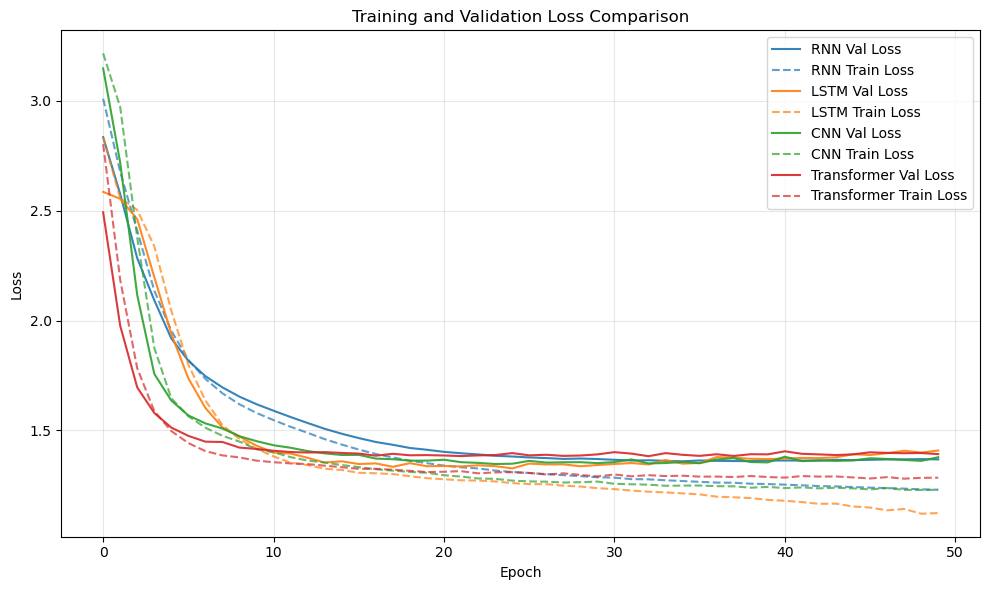

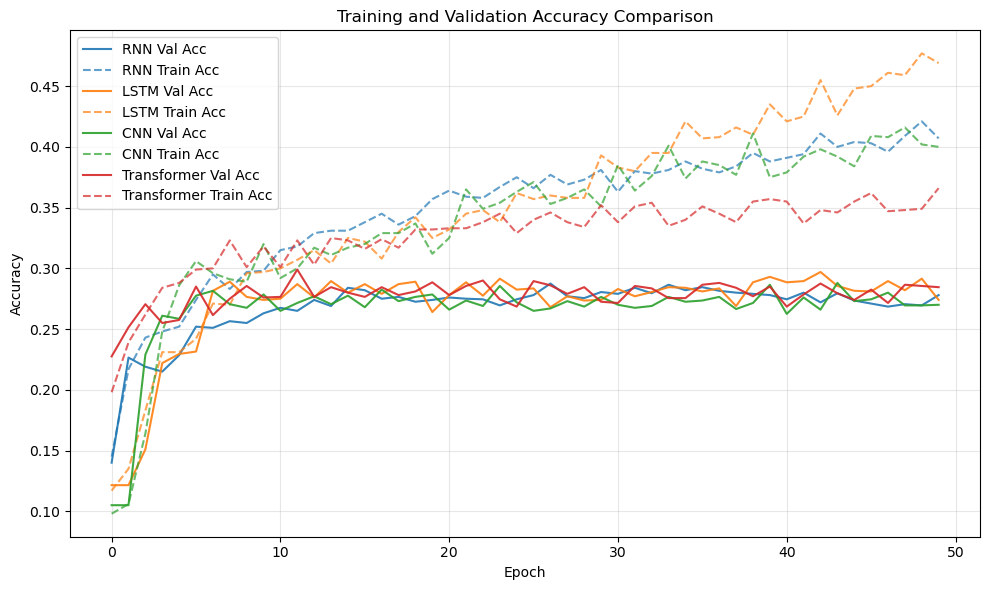

In [27]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss', linestyle='-', alpha=0.9, color='C0')
plt.plot(rnn_history.history['loss'], label='RNN Train Loss', linestyle='--', alpha=0.7, color='C0')

plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss', linestyle='-', alpha=0.9, color='C1')
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss', linestyle='--', alpha=0.7, color='C1')

plt.plot(cnn_history.history['val_loss'], label='CNN Val Loss', linestyle='-', alpha=0.9, color='C2')
plt.plot(cnn_history.history['loss'], label='CNN Train Loss', linestyle='--', alpha=0.7, color='C2')

plt.plot(transformer_history.history['val_loss'], label='Transformer Val Loss', linestyle='-', alpha=0.9, color='C3')
plt.plot(transformer_history.history['loss'], label='Transformer Train Loss', linestyle='--', alpha=0.7, color='C3')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Acc', linestyle='-', alpha=0.9, color='C0')
plt.plot(rnn_history.history['accuracy'], label='RNN Train Acc', linestyle='--', alpha=0.7, color='C0')

plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Acc', linestyle='-', alpha=0.9, color='C1')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Acc', linestyle='--', alpha=0.7, color='C1')

plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Acc', linestyle='-', alpha=0.9, color='C2')
plt.plot(cnn_history.history['accuracy'], label='CNN Train Acc', linestyle='--', alpha=0.7, color='C2')

plt.plot(transformer_history.history['val_accuracy'], label='Transformer Val Acc', linestyle='-', alpha=0.9, color='C3')
plt.plot(transformer_history.history['accuracy'], label='Transformer Train Acc', linestyle='--', alpha=0.7, color='C3')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()